In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score


/tmp/ipykernel_8102/890795445.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# First exploration, features engineering and variables encoding

In [2]:
data = pd.read_excel('Needs.xls')
data.head()

,ID,Age,Gender,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment
0,1,60,0,2,0.228685,0.233355,68.181525,53.260067,0,1
1,2,78,0,2,0.358916,0.170911,21.807595,135.550048,1,0
2,3,33,1,2,0.317515,0.249703,23.252747,66.303678,0,1
3,4,69,1,4,0.767685,0.654597,166.189034,404.997689,1,1
4,5,58,0,3,0.429719,0.349039,21.186723,58.911930,0,0


We start by visualizing the distributions of numerical features of our dataset in order to have a better understanding of it.

<Figure size 432x288 with 0 Axes>

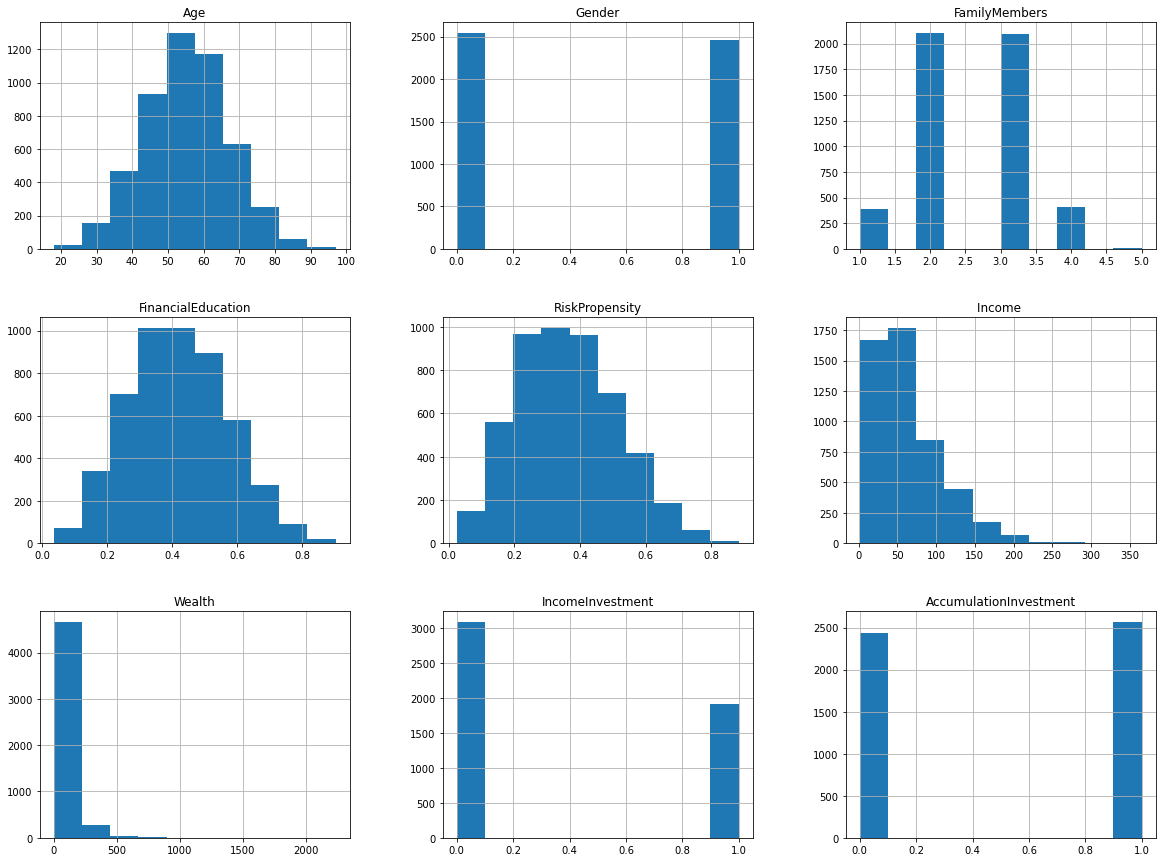

In [3]:
# Visualize the distributions of numerical features
plt.figure()
data.iloc[:, 1:].hist(figsize=(20, 15))
plt.show()

The correlation heatmap provides a visual representation of the correlation coefficients between pairs of features, highlighting strong positive or negative correlations. We can see a decent correlation for the couples RiskPropensity-FinancialEducation and Welth-Income

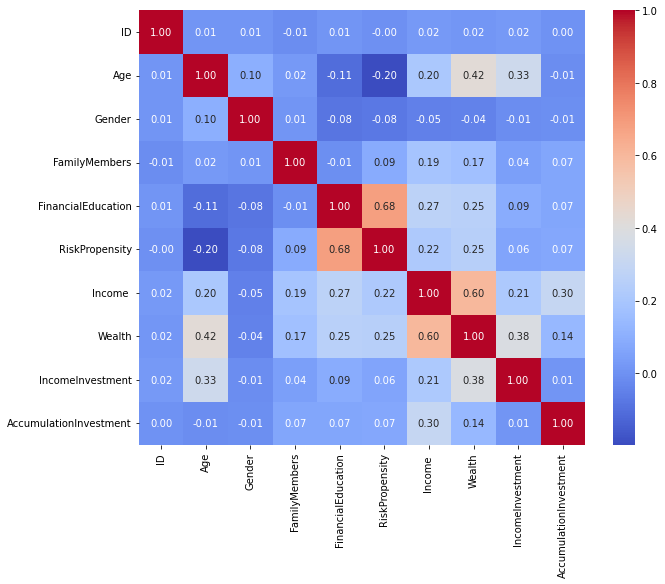

In [4]:
#Correlation matrix before data modeling
corr = data.corr(method = 'pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot = True, cmap='coolwarm', fmt=".2f")
plt.show()


We check for duplicated rows that can significantly impact the performance and accuracy of the models. We also want to avoid errors originated by null values, so we check if there is any. Finally, we print some info about the dataset.

In [5]:
# Checking for duplicate rows
duplicated_rows = data.duplicated()
drows = 0
for i in duplicated_rows:
    if i == True:
        drows = 1
        print(i)
if drows == 0:
    print("No duplicate rows")
else:
    print("are duplicate rows")

No duplicate rows


In [6]:
# Check for missing values
print(data.isnull().sum()) # No Nan value

ID                        0
Age                       0
Gender                    0
FamilyMembers             0
FinancialEducation        0
RiskPropensity            0
Income                    0
Wealth                    0
IncomeInvestment          0
AccumulationInvestment    0
dtype: int64


In [7]:
data.shape # 5000 x 10
data.describe()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      5000 non-null   int64  
 1   Age                     5000 non-null   int64  
 2   Gender                  5000 non-null   int64  
 3   FamilyMembers           5000 non-null   int64  
 4   FinancialEducation      5000 non-null   float64
 5   RiskPropensity          5000 non-null   float64
 6   Income                  5000 non-null   float64
 7   Wealth                  5000 non-null   float64
 8   IncomeInvestment        5000 non-null   int64  
 9   AccumulationInvestment  5000 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 390.8 KB


,ID,Age,Gender,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment
0,1,60,0,2,0.228685,0.233355,68.181525,53.260067,0,1
1,2,78,0,2,0.358916,0.170911,21.807595,135.550048,1,0
2,3,33,1,2,0.317515,0.249703,23.252747,66.303678,0,1
3,4,69,1,4,0.767685,0.654597,166.189034,404.997689,1,1
4,5,58,0,3,0.429719,0.349039,21.186723,58.911930,0,0


<h2>Feature Engineering and Dataset Modification</h2>



In this section, we delve into feature engineering to enhance the dataset for modeling purposes. We consider the addition or removal of features based on insights from the correlation matrix and Variance Inflation Factor (VIF) calculations.

We begin by examining the correlation matrix before data modeling to understand the relationships between features. Notably, there is a significant correlation observed between 'RiskPropensity-FinancialEducation' and 'Wealth-Income'.


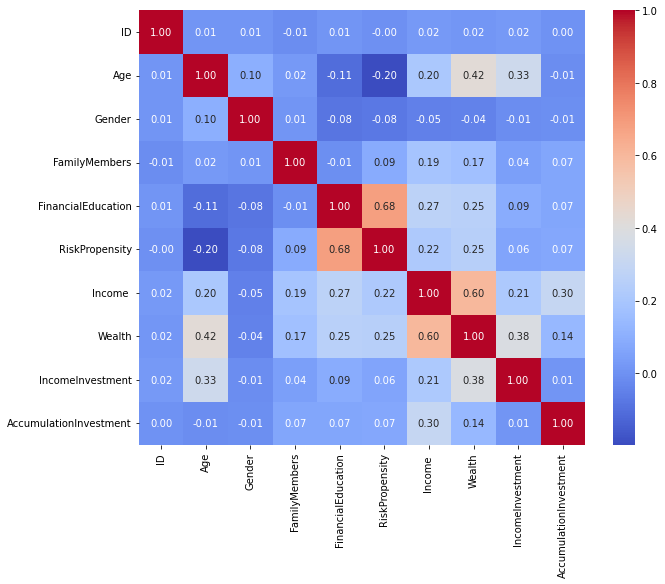

In [8]:
#Correlation matrix before data modeling
corr = data.corr(method = 'pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot = True, cmap='coolwarm', fmt=".2f")
plt.show()


Next, we calculate the VIF values to assess multicollinearity among the features. The low VIF values indicate no issues of multicollinearity, allowing us to proceed with feature modifications.

In [9]:
data_with_const = data.drop(['AccumulationInvestment', 'IncomeInvestment'], axis=1)

# Add a constant term to the independent variables
data_with_const = add_constant(data_with_const)

# Create a DataFrame to store the VIF results
vif_data = pd.DataFrame()
vif_data["Feature"] = data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])]

# Display the VIF results
print(vif_data)

              Feature        VIF
0               const  59.378533
1                  ID   1.001243
2                 Age   1.402608
3              Gender   1.021980
4       FamilyMembers   1.063089
5  FinancialEducation   1.963389
6      RiskPropensity   2.053734
7             Income    1.628217
8              Wealth   2.005004


We can conclude that there are no problems of multicollinearity, since all the VIF values are low. In addition, we decide to create a new feature 'Income/Wealth' beacuse of their correlation, and to remove the 'ID' feature that does not contribute to our objective.

In [10]:
data['Income/Wealth'] = data['Income '] / data['Wealth']
data = data.drop(['ID'], axis=1)


After modifying the dataset, we visualize the correlation matrix and the VIF values to observe the impact of the feature engineering steps on the relationships between variables.

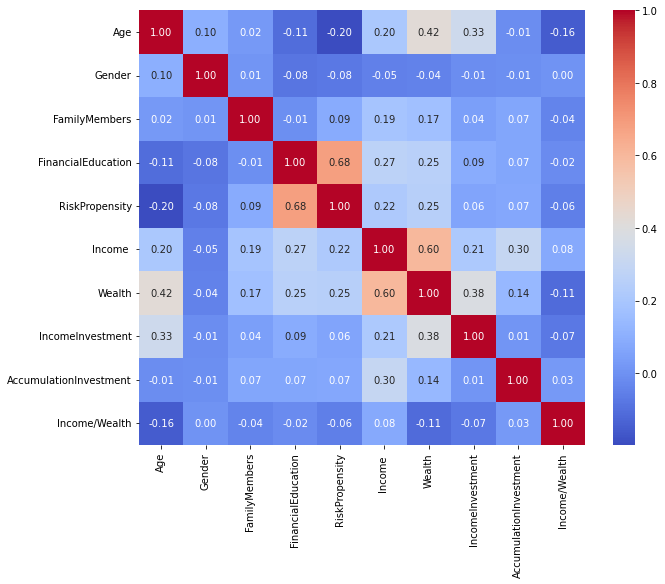

In [11]:
#Correlation after data modeling
corr = data.corr(method = 'pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot = True, cmap='coolwarm', fmt=".2f")
plt.show()


In [12]:
data_with_const = data.drop(['AccumulationInvestment', 'IncomeInvestment'], axis=1)

# Add a constant term to the independent variables
data_with_const = add_constant(data_with_const)

# Create a DataFrame to store the VIF results
vif_data = pd.DataFrame()
vif_data["Feature"] = data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])]

# Display the VIF results
print(vif_data)

              Feature        VIF
0               const  57.934371
1                 Age   1.428808
2              Gender   1.022123
3       FamilyMembers   1.065232
4  FinancialEducation   1.963482
5      RiskPropensity   2.064896
6             Income    1.688437
7              Wealth   2.032510
8       Income/Wealth   1.074589


<p><h2>Analyzing Feature Importances with Random Forest</h2></p>
<p>In this section, we will leverage the power of the Random Forest algorithm to gain valuable insights into the feature importances within our dataset. By understanding which features contribute most significantly to the target variable, we can make informed decisions about feature selection and model optimization.</p>
To begin, we will fit a Random Forest model to our dataset and extract the feature importance scores. This process involves creating multiple decision trees on random subsets of the training data and then combining their predictions to produce the final output.


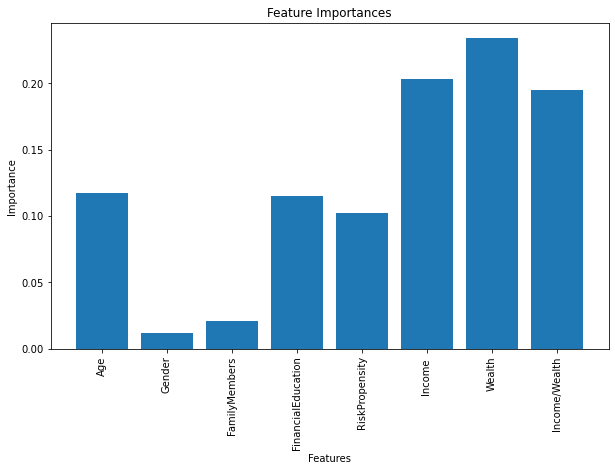

In [13]:
# Define the variable 'y' and 'x'
y = data['AccumulationInvestment'] | data['IncomeInvestment']  # Combine both conditions using logical OR
x = data.drop(['AccumulationInvestment', 'IncomeInvestment'], axis=1)

# Compute feature importances using a tree-based model before data modeling
model = RandomForestRegressor()
model.fit(x, y)
feature_importances = model.feature_importances_

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), x.columns, rotation=90)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


It is clear from the plot that the features 'Gender' and 'FamilyMembers' have minimal impact on the model's predictions, so they could potentially be candidates for removal to improve the model's efficiency and performance. Moreover, features with very low importance scores may introduce noise or unnecessary complexity to the model without adding valuable information for prediction.

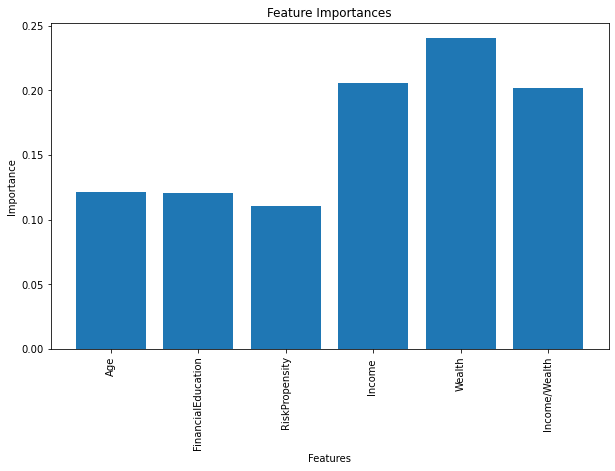

In [14]:
# We drop the columns 'Gender' and 'FamilyMembers' from the dataset as they are not relevant for the analysis
data = data.drop(['Gender', 'FamilyMembers'], axis=1)


# Now we compute again the feature importances using thee random forest model
x = x.drop(['Gender', 'FamilyMembers'], axis=1)
model = RandomForestRegressor()
model.fit(x, y)
feature_importances = model.feature_importances_

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), x.columns, rotation=90)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

<Figure size 432x288 with 0 Axes>

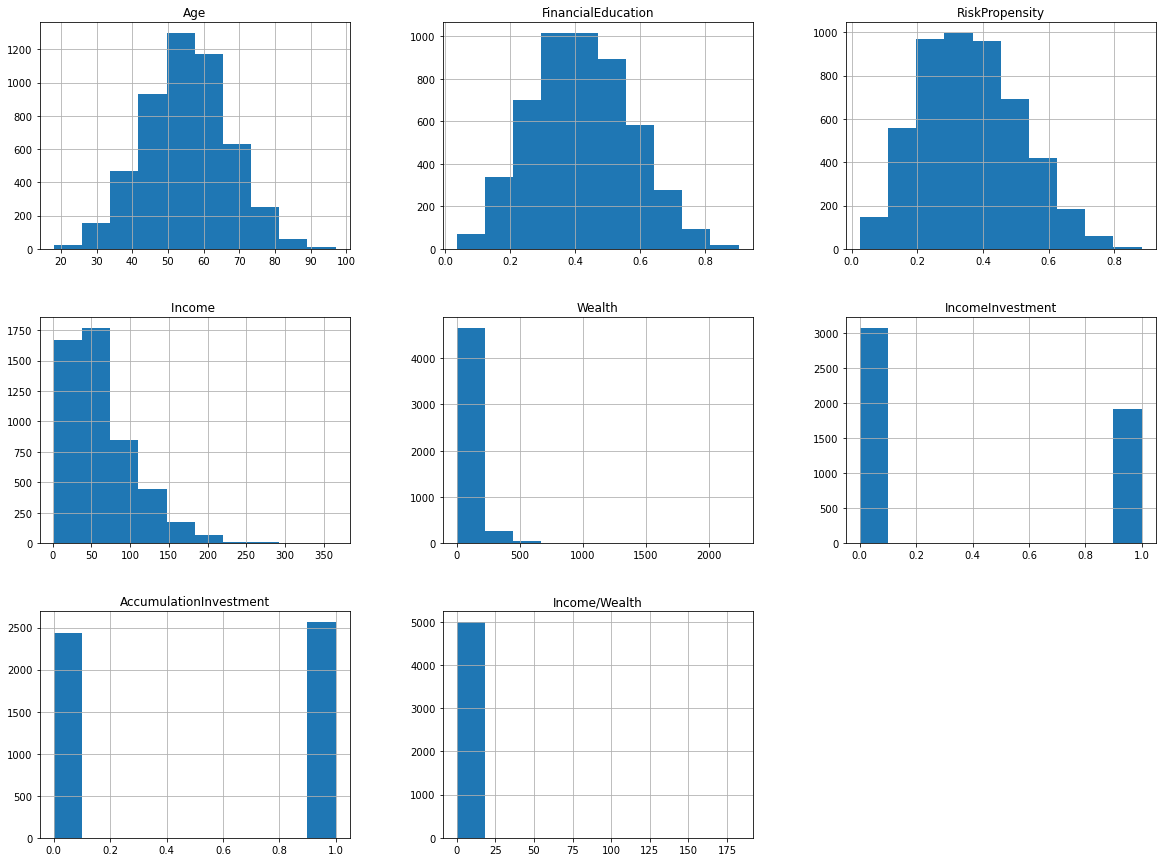

In [15]:
# Visualize the distributions of numerical features after feature engineering
plt.figure()
data.iloc[:, :].hist(figsize=(20, 15))
plt.show()

In [16]:
data.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment,Income/Wealth
0,60,0.228685,0.233355,68.181525,53.260067,0,1,1.280162
1,78,0.358916,0.170911,21.807595,135.550048,1,0,0.160882
2,33,0.317515,0.249703,23.252747,66.303678,0,1,0.350701
3,69,0.767685,0.654597,166.189034,404.997689,1,1,0.410346
4,58,0.429719,0.349039,21.186723,58.911930,0,0,0.359634


We noticed that the 'Income ' column contains an unnecessary space in its name. Let's remove it

In [17]:
new_col = list(data.columns)
new_col[3] = 'Income'
data.columns = new_col

print( "after changing column name: " )
data.head()

after changing column name: 


,Age,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment,Income/Wealth
0,60,0.228685,0.233355,68.181525,53.260067,0,1,1.280162
1,78,0.358916,0.170911,21.807595,135.550048,1,0,0.160882
2,33,0.317515,0.249703,23.252747,66.303678,0,1,0.350701
3,69,0.767685,0.654597,166.189034,404.997689,1,1,0.410346
4,58,0.429719,0.349039,21.186723,58.911930,0,0,0.359634


<p><h2>Analyzing Asymmetric Features with Log Transformation</h2></p>
<p>In this section, we will focus on the asymmetric features within our dataset and apply a log transformation to address their skewed distributions. By focusing on these features and applying a log transformation, we aim to enhance the quality of our data analysis and modeling processes, leading to more robust and reliable insights from the dataset.
<p>To begin, we will visualize the distributions of the asymmetric features 'Income', 'Wealth', and 'Income/Wealth' using histograms to understand their original distributions.</p>


<Figure size 432x288 with 0 Axes>

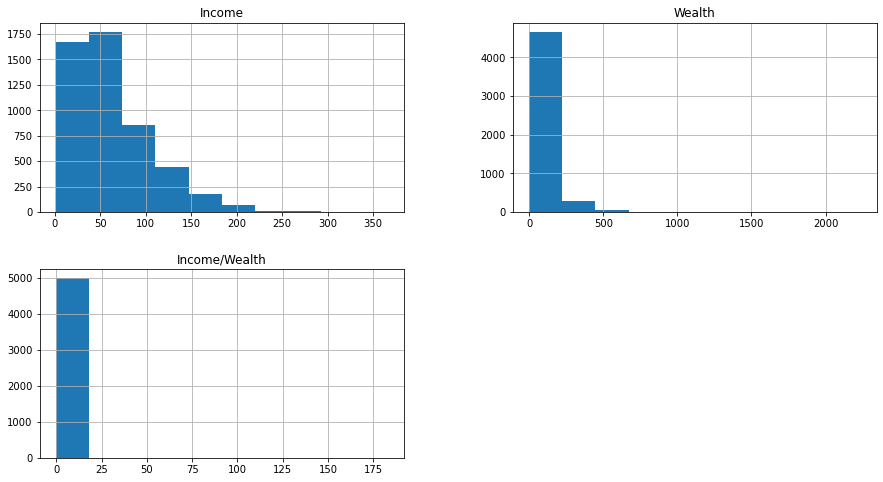

In [18]:
# Focus on the asymmetric features
plt.figure()
data.loc[:, ['Income', 'Wealth', 'Income/Wealth']].hist(figsize=(15, 8))
plt.show()

Due to the asymmetric nature of the 'Income', 'Wealth', and 'Income/Wealth' features, we will perform a log transformation to normalize their distributions.

In [19]:
# Log transformation
data.loc[:, 'Income'] = np.log(data.loc[:, 'Income'])
data.loc[:, 'Wealth'] = np.log(data.loc[:, 'Wealth'])
data.loc[:, 'Income/Wealth'] = np.log(data.loc[:, 'Income/Wealth'])
# data.loc[:, 'RiskPropensity/FinancialEducation'] = np.log(data.loc[:, 'RiskPropensity/FinancialEducation'])

<p>The histograms of the transformed features reveal how the log transformation has affected the distributions, leading to more symmetrical and normalized data for further analysis.</p>

<Figure size 432x288 with 0 Axes>

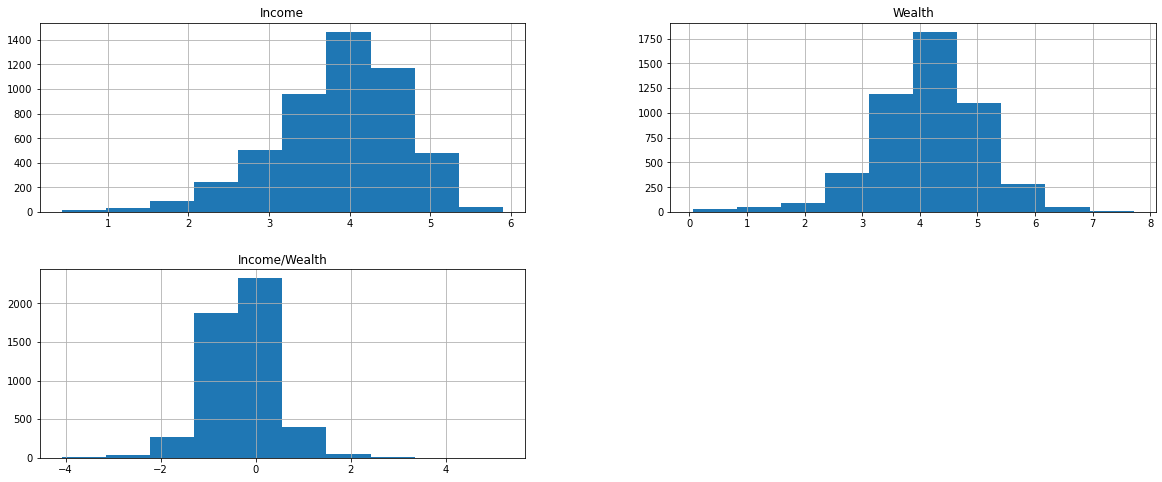

In [20]:
# Plot the transformed feature distributions
plt.figure()
data.loc[:, ['Income', 'Wealth', 'Income/Wealth']].hist(figsize=(20, 8))
plt.show()

<p><h2>Preprocessing Data and Encoding Features</h2></p>
<p>In this section, we will preprocess the dataset by encoding categorical variables and normalizing numerical features to prepare the data for modeling. By applying One-Hot Encoding to categorical variables and Min-Max Scaling to numerical variables, we aim to standardize the data and ensure compatibility with machine learning algorithms.</p>



<p>First, we define response variables based on 'IncomeInvestment' and 'AccumulationInvestment' columns to categorize investments as 'BothInvestment' or 'NoneInvestment'.</p>



In [21]:
# Response variables
IncInv = data.loc[:,'IncomeInvestment']
AccInv = data.loc[:,'AccumulationInvestment']
BothInv = (IncInv == True) & (AccInv == True)
NoneInv = (IncInv == False) & (AccInv == False)

We drop the 'IncomeInvestment' and 'AccumulationInvestment' columns and categorize features based on the number of unique values for further processing.

In [22]:
data = data.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
threshold = 4
unique_counts = data.apply(lambda x: x.nunique())
cat_data = data.loc[:, unique_counts < threshold]
num_data = data.loc[:, unique_counts >= threshold]

We use One-Hot Encoding for categorical features and Min-Max Scaling for numerical features to standardize the data.

In [23]:
# categorical features
encoder = OneHotEncoder(drop='first')
cat_data_encoded = encoder.fit_transform(cat_data)
encoded_columns_cat = encoder.get_feature_names_out(cat_data.columns)

# numerical features
scaler = MinMaxScaler()
num_data_normalized = scaler.fit_transform(num_data)
encoded_columns_num = scaler.get_feature_names_out(num_data.columns)

We concatenate the encoded categorical and normalized numerical features to create the final feature matrix 'X'.

In [24]:
X = pd.concat([pd.DataFrame(cat_data_encoded.toarray(), columns=encoded_columns_cat), pd.DataFrame(num_data_normalized, columns=encoded_columns_num)], axis=1)

We merge the response variables with the encoded dataset to include 'BothInvestment' and 'NoneInvestment' labels.

In [25]:
X_resp = pd.concat([X, IncInv, AccInv, BothInv.astype(int), NoneInv.astype(int)], axis=1)
col = list(X_resp.columns)
col[-1] = 'NoneInvestment'
col[-2] = 'BothInvestment'
X_resp.columns = col
X_resp.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,IncomeInvestment,AccumulationInvestment,BothInvestment,NoneInvestment
0,0.531646,0.222172,0.243105,0.693150,0.511975,0.466159,0,1,0,0
1,0.759494,0.372410,0.170321,0.484773,0.634001,0.242923,1,0,0,0
2,0.189873,0.324649,0.262161,0.496502,0.540590,0.326796,0,1,0,0
3,0.645570,0.843975,0.734110,0.856016,0.776977,0.343701,1,1,1,0
4,0.506329,0.454090,0.377948,0.479493,0.525149,0.329503,0,0,0,1


Finally, we save the encoded dataset with all four possible investment labels to an Excel file for further analysis.

In [26]:
excel_file_path = "Needs_dataset_encoded.xlsx"
X_resp.to_excel(excel_file_path, index=False)

<p><h2>Analyzing Feature Correlations and Filtering Dataset</h2></p>
<p>In this section, we will explore the correlations between features in the dataset and apply a correlation-based feature selection technique to remove redundant variables. By analyzing the correlation matrix and applying a correlation threshold, we aim to simplify the dataset while preserving the most informative features.</p>

We start by loading the encoded dataset from an Excel file and displaying the first few rows to ensure the data is loaded correctly.

In [27]:
data = pd.read_excel('Needs_dataset_encoded.xlsx')
data.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,IncomeInvestment,AccumulationInvestment,BothInvestment,NoneInvestment
0,0.531646,0.222172,0.243105,0.693150,0.511975,0.466159,0,1,0,0
1,0.759494,0.372410,0.170321,0.484773,0.634001,0.242923,1,0,0,0
2,0.189873,0.324649,0.262161,0.496502,0.540590,0.326796,0,1,0,0
3,0.645570,0.843975,0.734110,0.856016,0.776977,0.343701,1,1,1,0
4,0.506329,0.454090,0.377948,0.479493,0.525149,0.329503,0,0,0,1


We calculate the Pearson correlation matrix for the entire dataset to assess the relationships between features.

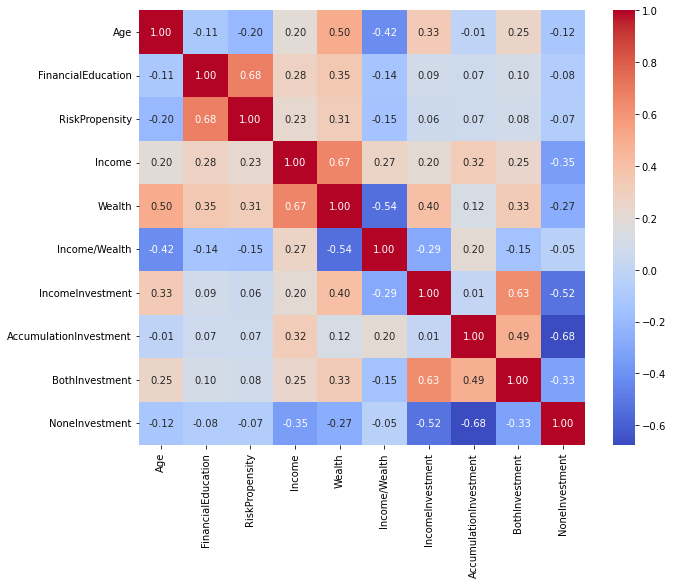

In [28]:
corr = data.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

We implement a correlation-based feature selection technique to identify and remove features that have low correlation with all other features. This process helps to reduce redundancy and dimensionality in the dataset.   
By setting a correlation threshold, we specify the minimum correlation required for a feature to be retained. Features with a second-highest correlation coefficient below the threshold are considered redundant and are removed from the dataset.

In [29]:
threshold = 0.3
columns_to_drop = []

for column in corr.columns:
    corr_sorted = corr.loc[:, column].abs().sort_values(ascending=False)
    if corr_sorted.iloc[1] < threshold:
        columns_to_drop.append(column)

data_drop = data.drop(columns=columns_to_drop)
print(f'Columns dropped: ', columns_to_drop)
data_drop.head()

Columns dropped:  []


,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,IncomeInvestment,AccumulationInvestment,BothInvestment,NoneInvestment
0,0.531646,0.222172,0.243105,0.693150,0.511975,0.466159,0,1,0,0
1,0.759494,0.372410,0.170321,0.484773,0.634001,0.242923,1,0,0,0
2,0.189873,0.324649,0.262161,0.496502,0.540590,0.326796,0,1,0,0
3,0.645570,0.843975,0.734110,0.856016,0.776977,0.343701,1,1,1,0
4,0.506329,0.454090,0.377948,0.479493,0.525149,0.329503,0,0,0,1


In this case, no feature has been removed

<p><h2>Filtering the Dataset to Focus on Relevant Clients</h2><p>
The goal of this section is to filter the dataset to remove clients who have no preference for either income or accumulation investment products. From an economic perspective, these clients are not as interesting to target, as our aim is to sell products to those with at least some investment preference.


We start by visualizing the distributions of the 'IncomeInvestment' and 'AccumulationInvestment' labels in the original dataset.

In [30]:
# Original dataset
X_II_AI = data_drop.iloc[:, :8]
X_II_AI.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,IncomeInvestment,AccumulationInvestment
0,0.531646,0.222172,0.243105,0.693150,0.511975,0.466159,0,1
1,0.759494,0.372410,0.170321,0.484773,0.634001,0.242923,1,0
2,0.189873,0.324649,0.262161,0.496502,0.540590,0.326796,0,1
3,0.645570,0.843975,0.734110,0.856016,0.776977,0.343701,1,1
4,0.506329,0.454090,0.377948,0.479493,0.525149,0.329503,0,0


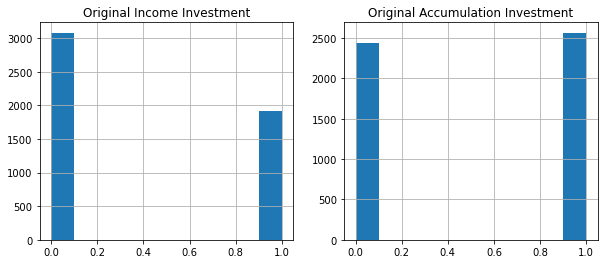

In [31]:
# Histogram of IncomeInvestment
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
X_II_AI.loc[:, 'IncomeInvestment'].hist()
plt.title('Original Income Investment')

plt.subplot(1, 2, 2)
X_II_AI.loc[:, 'AccumulationInvestment'].hist()
plt.title('Original Accumulation Investment')
plt.show()

The histograms show that the 'IncomeInvestment' label is unbalanced, with more 0s than 1s. However, some of the 0s correspond to clients with no investment preferences, which are likely not of interest to target. This imbalance can affect the classification performance, as the model may be more likely to misclassify the minority class (1s).


To address this issue, we remove clients who have no investment preferences (i.e., both 'IncomeInvestment' and 'AccumulationInvestment' are 0).


In [32]:
indexes_to_mantain = data_drop.loc[:, 'NoneInvestment'] == 0

client_to_remove = data_drop.loc[:, 'NoneInvestment'].sum() # without preferences
print(f'Clients without preferences, so to be removed:', client_to_remove)

# New dataset
X = X_II_AI.loc[indexes_to_mantain, :]
print(f'New dataset shape:', X.shape)

Clients without preferences, so to be removed: 1514
New dataset shape: (3486, 8)


By removing these clients, the 'IncomeInvestment' label becomes more balanced, while the 'AccumulationInvestment' label becomes slightly unbalanced but with a higher presence of the positive class.


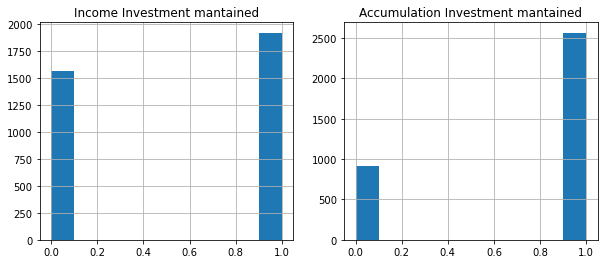

In [33]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
data_drop.loc[indexes_to_mantain, 'IncomeInvestment'].hist() # more balanced
plt.title('Income Investment mantained')

plt.subplot(1, 2, 2)
data_drop.loc[indexes_to_mantain, 'AccumulationInvestment'].hist() # unbalanced but with more 1s
plt.title('Accumulation Investment mantained')
plt.show()

<Figure size 720x720 with 0 Axes>

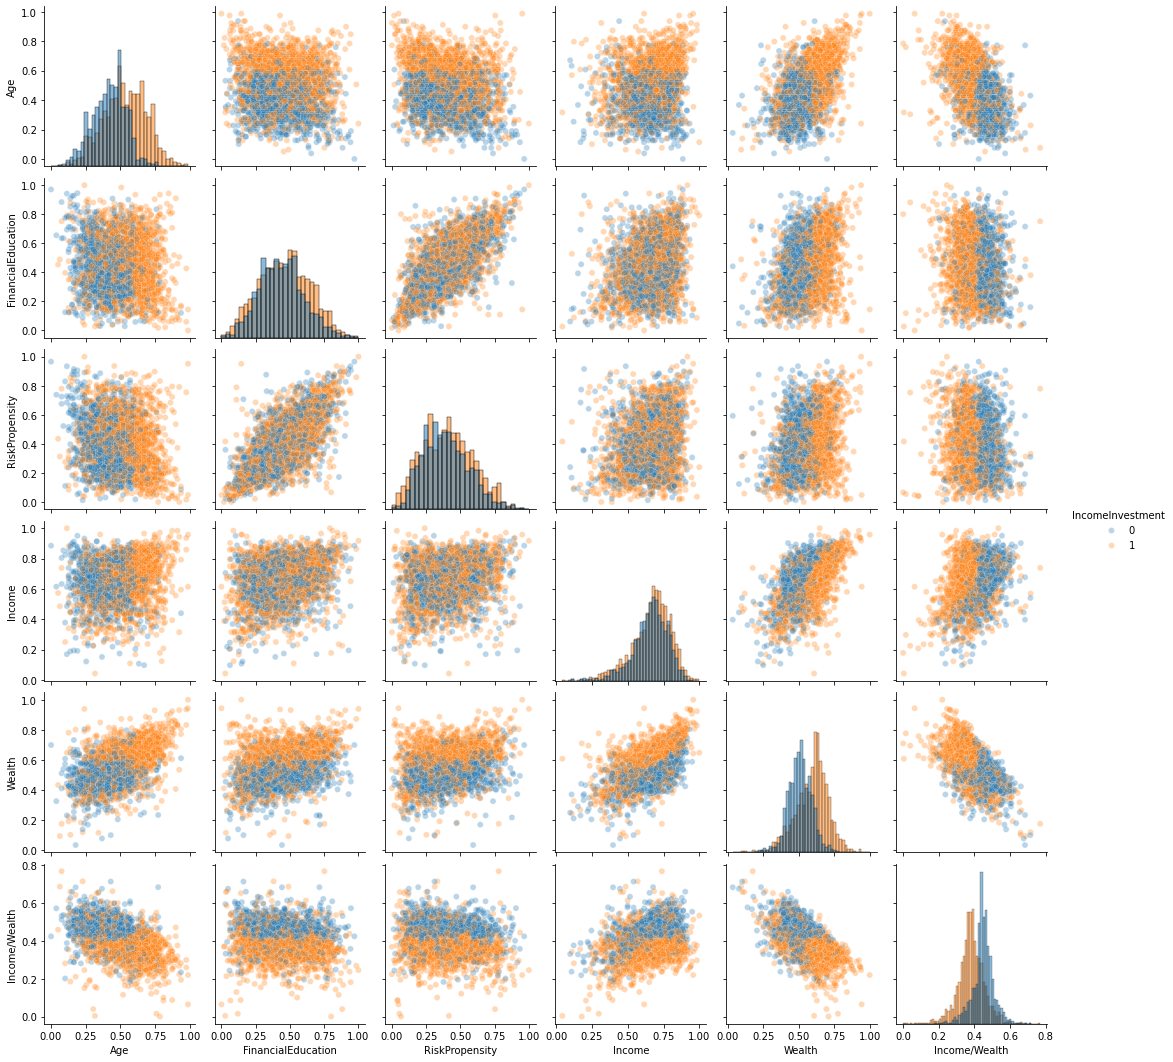

In [34]:
# Scatterplot according to IncomeInvestment on the remaining clients
plt.figure(figsize=(10, 10))
sns.pairplot(X.iloc[:, :7], hue='IncomeInvestment', diag_kind='hist', plot_kws={'alpha':0.3})
plt.show()

<h2>Confirming the Design Choice</h2>


To support the decision to filter the dataset, we train a Multi-Layer Perceptron (MLP) classifier on both the original and filtered datasets and compare the performance.


In [35]:
# MLP on the complete dataset
y_all = X_II_AI.loc[:, 'IncomeInvestment']
X_all = X_II_AI.drop(['IncomeInvestment','AccumulationInvestment'], axis=1)

# MLP on the filtered dataset
y = X.loc[:, 'IncomeInvestment']
X = X.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)

<h4>MLP on the Complete Dataset</h4>

We start by splitting the complete dataset into training and testing sets

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

Next, we initialize an MLP classifier with specific parameters such as the number of hidden layers and maximum iterations.   
The classifier is then trained on the training set.

In [37]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)

# Train the MLP classifier
mlp_classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)

After training, we make predictions on the test set.

In [38]:
# Make predictions on the test set
predictions = mlp_classifier.predict(X_test)

Finally, we calculate the accuracy score and recall score to evaluate the model's performance.

Accuracy: 0.804
Recall score: 0.5853018372703412


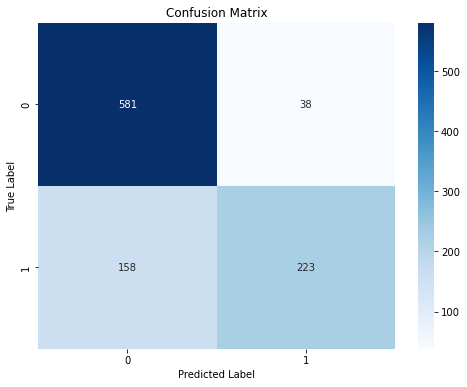

In [39]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calculate recall score
recall = recall_score(y_test, predictions)
print("Recall score:", recall)

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The accuracy score measures the overall correctness of the predictions, while the recall score focuses on the proportion of true positives that are correctly identified by the model.

<h4>MLP on the Filtered Dataset</h4>   


We repeat the process with the filtered dataset, which contains only clients with at least one investment preference.

Accuracy: 0.7535816618911175
Recall score: 0.75


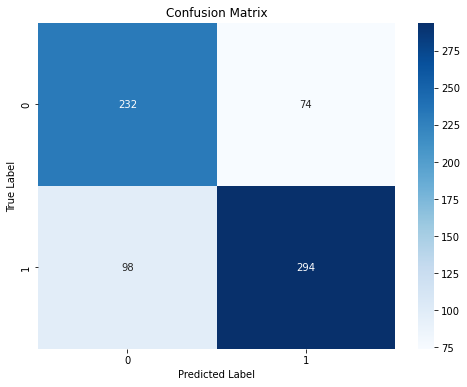

In [40]:
# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the MLP classifier on the filtered dataset
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = mlp_classifier.predict(X_test)

# Calculate accuracy and recall scores
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
recall = recall_score(y_test, predictions)
print("Recall score:", recall)

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
#plt.savefig('ConfusionMatrix_IncomeInvestmentReduced.png')
plt.show()

By comparing the results from the complete and filtered datasets, we observe a small decrease in accuracy but a significant improvement in recall when using the filtered dataset. Since our primary goal is to correctly identify clients with an income investment preference, the higher recall score makes the filtered dataset more suitable for our purposes.

<h2>Saving the Filtered Dataset and conclusions</h2>

Finally, we save the filtered dataset containing only the clients with at least one investment preference.


In [41]:
X = X_II_AI.loc[indexes_to_mantain, :]
excel_file_path = "DataIntrested.xlsx"
X.to_excel(excel_file_path, index=False)

In summary, by filtering the dataset to remove clients with no investment preferences, we have improved the balance of the 'IncomeInvestment' label and increased the model's ability to correctly identify clients with an income investment preference, which is the primary objective of this task.